In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os

In [2]:
symbol = 'BTCUSDT'
base_path = f"data/processed/{symbol.lower()}_50_30_prediction"
h5_file = base_path + '.h5'
input_times_file = base_path + '_input_times.npy'
output_times_file = base_path + '_output_times.npy'

In [3]:
with h5py.File(h5_file, 'r') as hf:
    inputs = hf['inputs'][:]      # shape: (N, 50)
    outputs = hf['outputs'][:]    # shape: (N, 30)

In [4]:
input_times = np.load(input_times_file)  # shape: (N, 50)
output_times = np.load(output_times_file)  # shape: (N, 30)


In [5]:
# === Normalize ===
scaler = MinMaxScaler()
scaler.fit(inputs.reshape(-1, 1))  # Assume Close only


MinMaxScaler()

In [6]:
# === Train-Validation Split ===
train_size = int(len(inputs) * 0.8)

In [7]:
val_inputs = inputs[train_size:]
val_outputs = outputs[train_size:]
val_input_times = input_times[train_size:]
val_output_times = output_times[train_size:]

In [8]:
# === Create Ground Truth ===
ground_true = np.concatenate([val_inputs, val_outputs], axis=1)
ground_true_times = np.concatenate([val_input_times, val_output_times], axis=1)

In [9]:
# Flatten for plotting
ground_true = ground_true.reshape(-1)
ground_true_times = pd.to_datetime(ground_true_times.reshape(-1))

In [10]:
# === Baseline 1: Last seen value repeated ===
# Predict last 16 prices from last part of input
predicted = val_inputs[:, -16:]  # shape: (val_size, 16)

In [11]:
# Invert normalization (simulate raw close values)
predicted_inverted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(predicted.shape)


In [12]:
# Flatten for comparison
predicted_flat = predicted_inverted.reshape(-1)
val_output_times_flat = pd.to_datetime(val_output_times[:, :16].reshape(-1))

In [13]:
# === Plotting ===
ground_df = pd.DataFrame({'times': ground_true_times, 'value': ground_true})
pred_df = pd.DataFrame({'times': val_output_times_flat, 'value': predicted_flat})

In [14]:
# Filter: Plot only a recent part of 2018 (or latest you have)
ground_df = ground_df[ground_df["times"] >= "2018-07-01"]
pred_df = pred_df[pred_df["times"] >= "2018-07-01"]

In [18]:
# Scale back actual values
ground_df['value'] = scaler.inverse_transform(ground_df['value'].values.reshape(-1,1)).reshape(-1)


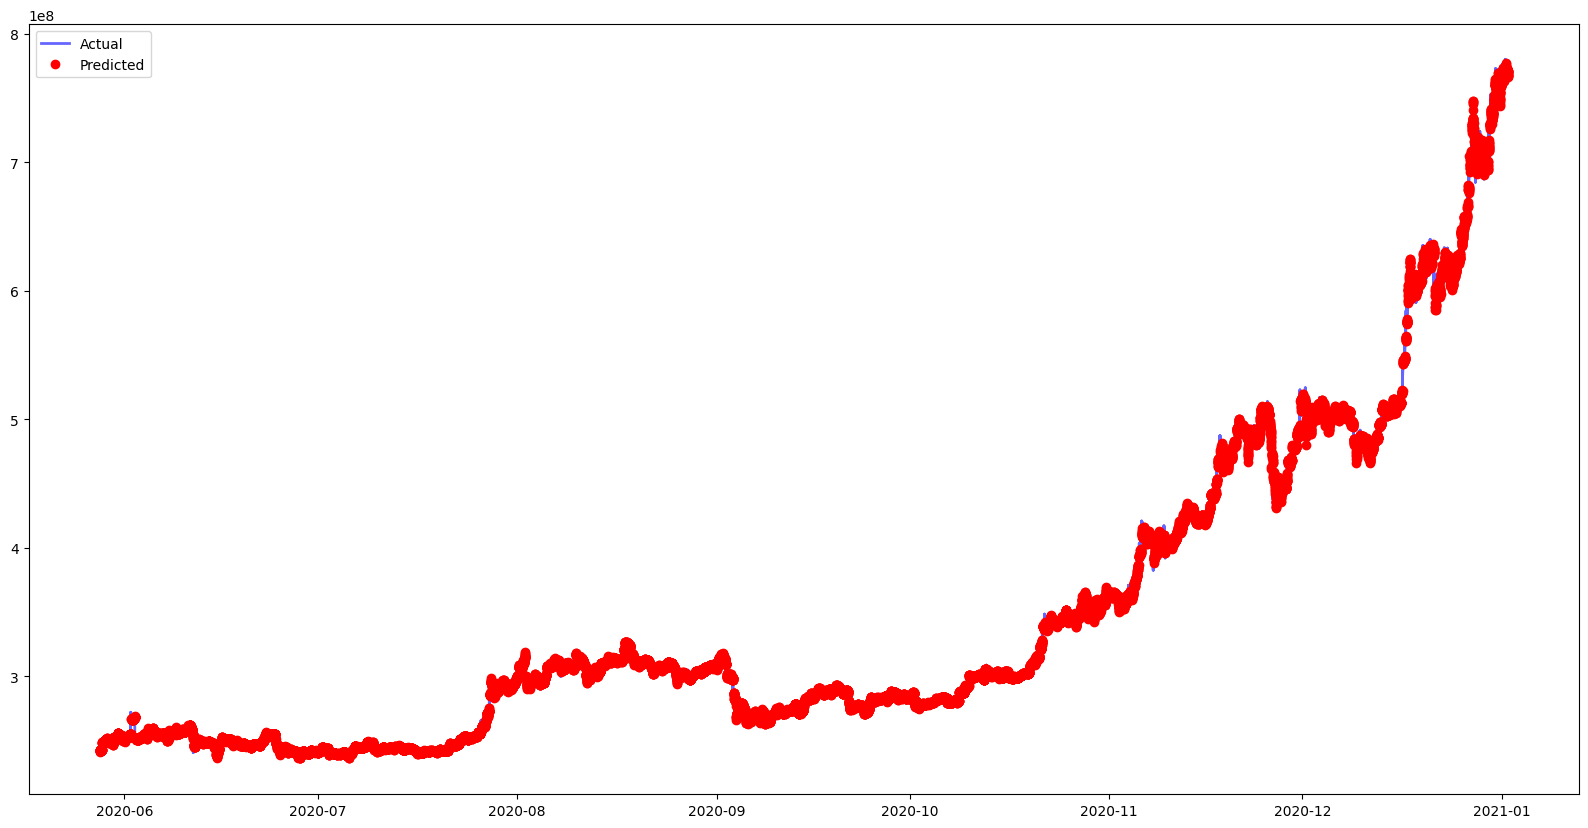

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(ground_df.times, ground_df.value, label="Actual", color='blue', linewidth=2, alpha=0.6)
plt.plot(pred_df.times, pred_df.value, 'ro', label="Predicted")
plt.legend(loc='upper left')
os.makedirs('result', exist_ok=True)
plt.savefig('result/binance_close_rw_baseline.png')
plt.show()

In [16]:
# === Evaluation ===
gt_vals = val_outputs[:, :16].reshape(-1)
gt_vals = scaler.inverse_transform(gt_vals.reshape(-1, 1)).reshape(-1)
